# Preprocess APO fluxes from CarboScope inversion

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import numpy as np

import cftime

import pandas as pd
import xarray as xr
import intake

import config
import regrid_tools
import util

## Read APO flux data

In [19]:
cat = intake.open_catalog("catalogs/fluxes-catalog-web.yml")
cat

fluxes-catalog-web:
  args:
    path: catalogs/fluxes-catalog-web.yml
  description: Flux datasets
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [20]:
version = "apo99_v2020"

### Fix `storage_options` to increase `timeout` 

In [21]:
import aiohttp
timeout = aiohttp.ClientTimeout(total=86400)
storage_options=dict(**cat[f"fgapo_CarbonScope_{version}"].storage_options)
storage_options.update(
    dict(
        http=dict(client_kwargs={'timeout': timeout}),
    )
)
storage_options

{'simplecache': {'same_names': True,
  'cache_storage': '/glade/work/mclong/sno-analysis/intake-cache/test'},
 'http': {'client_kwargs': {'timeout': ClientTimeout(total=86400, connect=None, sock_read=None, sock_connect=None)}}}

In [22]:
ds = cat[f"fgapo_CarbonScope_{version}"](storage_options=storage_options).to_dask().compute()            
ds

<xarray.Dataset>
Dimensions:        (lon: 144, nv: 2, lat: 90, itime: 11323, proc: 8, rt: 3, spec: 1, mtime: 7670, mtime0: 100)
Coordinates:
  * lon            (lon) float32 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat            (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * itime          (itime) int32 -315532800 -315446400 ... 662601600 662688000
  * proc           (proc) int32 1 2 3 4 5 6 7 8
  * rt             (rt) int32 1 2 3
  * spec           (spec) int32 1
  * mtime          (mtime) int32 -31492801 -31406401 ... 631022400 631108800
Dimensions without coordinates: nv, mtime0
Data variables: (12/16)
    lon_bounds     (lon, nv) float32 -180.0 -177.5 -177.5 ... 177.5 177.5 180.0
    lat_bounds     (lat, nv) float32 -90.0 -88.0 -88.0 -86.0 ... 88.0 88.0 90.0
    itime_bounds   (itime, nv) int32 -315532800 -315446400 ... 662774400
    dt             (itime) int32 86400 86400 86400 86400 ... 86400 86400 86400
    year           (itime) float64 1.99e+03 1.99e+03 ... 2.021e+03 2.021e+03
    lproc          (proc) |S20 b'ocL                 ' ... b'ini             ...
    ...             ...
    myear          (mtime) float64 1.999e+03 1.999e+03 ... 2.02e+03 2.02e+03
    tmask          (itime, mtime0) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    apoflux_land   (mtime, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    apoflux_ocean  (mtime, lat, lon) float32 0.0 0.0 0.0 ... 0.0009978 0.0009971
    apoflux_subt   (mtime, lat, lon) float32 0.0 0.0 0.0 ... 1.765e-05 2.051e-05
    apoflux_excl   (mtime, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    title:         Jena CarboScope results
    history:       Inversion code by Christian Roedenbeck
    institution:   MPI Biogeochemistry Jena
    references:    http://www.BGC-Jena.mpg.de/CarboScope/
    Conventions:   CF-1.1
    species:       apo
    ...            ...
    valid_period:  1999-2019 (inclusive)
    yrfi_valid:    1999
    yrfe_valid:    2019
    dirname:       OUTPUT13.033+tm3_ncep_fg.1990-2020_2Hx2.apo.-S-.apo97A+fbS...
    filename:      mu1.0_090_flux_asis+1999-2019.nc
    c0:            -18.0

In [23]:
ds.apoflux_ocean.attrs

{'long_name': 'Ocean-atmosphere apo flux',
 'units': 'Tmol/yr',
 'cell_methods': 'lon: lat: sum',
 'cell_measures': 'area: dxyp'}

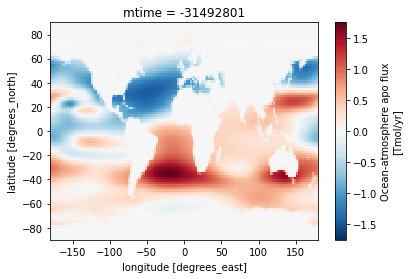

In [24]:
ds.apoflux_ocean.isel(mtime=0).plot()

In [25]:
grid = util.generate_latlon_grid(nx=ds.lon.size, ny=ds.lat.size, lon0=-180.)
np.testing.assert_array_almost_equal(grid.lon.values, ds.lon.values)
np.testing.assert_array_almost_equal(grid.lat.values, ds.lat.values)

src_grid = regrid_tools.grid("latlon", nx=ds.lon.size, ny=ds.lat.size, lon0=-180.)
src_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_2.5x2.0_lon0=-180.0.nc


grid: latlon_latlon_2.5x2.0_lon0=-180.0
dims: (90, 144)
file: /glade/scratch/mclong/tmp/regridding/latlon_2.5x2.0_lon0=-180.0.nc

In [26]:
dt = ds.dt.values[0]
np.testing.assert_equal(ds.dt.values, dt)

In [27]:
Tmolyr_to_mols = 1e12 / 365. / 86400.
flux_variables = dict(
    fgapo_ocn="apoflux_ocean",
    fgapo_lnd="apoflux_land",
    fgapo_fff="apoflux_subt",
    fgapo_exc="apoflux_excl",
)
dso_src = ds[["mtime", "lat", "lon"]]
for var_out, var_in in flux_variables.items():    
    dso_src[var_out] = ds[var_in] / ds.dxyp * Tmolyr_to_mols
    dso_src[var_out].attrs = ds[var_in].attrs
    dso_src[var_out].attrs["units"] = "mol/m^2/s"
    del dso_src[var_out].attrs["cell_measures"]
    dso_src[var_out].encoding = ds[var_in].encoding
    
dso_src = dso_src.rename({"mtime": "time"})
dso_src.time.attrs = ds.mtime.attrs
dso_src.time.encoding["_FillValue"] = None
dso_src

<xarray.Dataset>
Dimensions:    (time: 7670, lat: 90, lon: 144)
Coordinates:
  * time       (time) int32 -31492801 -31406401 ... 631022400 631108800
  * lat        (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
Data variables:
    fgapo_ocn  (time, lat, lon) float32 0.0 0.0 0.0 ... 2.929e-08 2.927e-08
    fgapo_lnd  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fgapo_fff  (time, lat, lon) float32 0.0 0.0 0.0 ... 5.182e-10 6.019e-10
    fgapo_exc  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    title:         Jena CarboScope results
    history:       Inversion code by Christian Roedenbeck
    institution:   MPI Biogeochemistry Jena
    references:    http://www.BGC-Jena.mpg.de/CarboScope/
    Conventions:   CF-1.1
    species:       apo
    ...            ...
    valid_period:  1999-2019 (inclusive)
    yrfi_valid:    1999
    yrfe_valid:    2019
    dirname:       OUTPUT13.033+tm3_ncep_fg.1990-2020_2Hx2.apo.-S-.apo97A+fbS...
    filename:      mu1.0_090_flux_asis+1999-2019.nc
    c0:            -18.0

In [37]:
cftime.num2date(dso_src.time, units=dso_src.time.units)

array([cftime.DatetimeGregorian(1999, 1, 1, 11, 59, 59, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1999, 1, 2, 11, 59, 59, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1999, 1, 3, 11, 59, 59, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(2019, 12, 29, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 12, 30, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 12, 31, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)

In [28]:
dst_grid = regrid_tools.grid("latlon", **config.config_dict["flux-dst-grid-kwargs"])
dst_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc


grid: latlon_latlon_1.0x1.0_lon0=-180.0
dims: (180, 360)
file: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc

In [29]:
regrid_obj = regrid_tools.regridder(src_grid, dst_grid, method="conserve", clobber=False)
regrid_obj

source grid dims: (90, 144)
destination grid dims: (180, 360)


regridder latlon_2.5x2.0_lon0=-180.0.nc --> latlon_1.0x1.0_lon0=-180.0.nc

In [31]:
dso = util.generate_latlon_grid(**config.config_dict["flux-dst-grid-kwargs"])[["area"]]

dso_dst_data = regrid_obj(dso_src)
dso["time"] = dso_src.time

for v in dso_dst_data.data_vars:
    dso[v] = dso_dst_data[v]
    dso[v].encoding = dso_src[v].encoding
    
time = cftime.num2date(dso.time, units=dso.time.attrs["units"])    
dso

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 7670)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time       (time) int32 -31492801 -31406401 ... 631022400 631108800
Data variables:
    area       (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    fgapo_ocn  (time, lat, lon) float64 0.0 0.0 0.0 ... 2.927e-08 2.927e-08
    fgapo_lnd  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fgapo_fff  (time, lat, lon) float64 0.0 0.0 0.0 ... 6.019e-10 6.019e-10
    fgapo_exc  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [32]:
file_out = f"{config.flux_product_dir}/fgapo_ocn.CarboScope.{version}.nc"

util.to_netcdf_clean(dso, file_out, format='NETCDF4')

------------------------------
Writing /glade/work/mclong/sno-analysis/flux-products/fgapo_ocn.CarboScope.apo99_v2020.nc
netcdf fgapo_ocn.CarboScope.apo99_v2020 {
dimensions:
	lat = 180 ;
	lon = 360 ;
	time = 7670 ;
variables:
	double lat(lat) ;
	double lon(lon) ;
	float area(lat, lon) ;
		area:_FillValue = 9.96921e+36f ;
		area:units = "m^2" ;
		area:long_name = "area" ;
	int time(time) ;
		time:long_name = "output time" ;
		time:standard_name = "time" ;
		time:units = "seconds since 2000-01-01" ;
	float fgapo_ocn(time, lat, lon) ;
		fgapo_ocn:_FillValue = 9.96921e+36f ;
		fgapo_ocn:long_name = "Ocean-atmosphere apo flux" ;
		fgapo_ocn:units = "mol/m^2/s" ;
		fgapo_ocn:cell_methods = "lon: lat: sum" ;
	float fgapo_lnd(time, lat, lon) ;
		fgapo_lnd:_FillValue = 9.96921e+36f ;
		fgapo_lnd:long_name = "Land-atmosphere apo flux" ;
		fgapo_lnd:units = "mol/m^2/s" ;
		fgapo_lnd:cell_methods = "lon: lat: sum" ;
	float fgapo_fff(time, lat, lon) ;
		fgapo_fff:_FillValue = 9.96921e+36f ;
		fgap

In [38]:
curator = util.curate_flux_products()
curator.add_source(
        key=f"fgapo.carboscope.{version}",
        urlpath=file_out,
        description=f'APO fluxes from CarboScope inversion {version}',
    )